In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Category to Product mapping and weights
category_product_map = {
    "topup": ["ntc_topup", "ncell_topup", "smartcell_topup"],
    "bank_transaction": ["bank_withdrawal", "bank_deposit"],
    "bill_payment": ["electricity_bill", "water_bill", "internet_bill"],
    "entertainment": ["movie_ticket", "airline_ticket"],
    "loan": ["loan_repayment", "credit_card_payment"],
    "government": ["tax_payment", "govt_fee"],
    "insurance": ["insurance_payment"],
    "education": ["school_fee"],
    "shopping": ["online_shopping", "mobile_data_pack"]
}

category_weights = {
    "topup": 10,
    "bank_transaction": 6,
    "bill_payment": 8,
    "entertainment": 3,
    "loan": 5,
    "government": 3,
    "insurance": 4,
    "education": 5,
    "shopping": 7
}

# Festivals with format month-day and transaction multiplier
festivals = {
    "New Year Nepali": ("04-13", 3),
    "New Year English": ("01-01", 2.5),
    "Mother's Day": ("05-09", 1.5),
    "Buddha Jayanti": ("05-13", 1.8),
    "Teej": ("08-26", 2),
    "Indra Jatra": ("09-05", 1.5),
    "Dashain Day 1": ("10-05", 3),
    "Dashain Day 2": ("10-06", 3),
    "Dashain Day 3": ("10-07", 3),
    "Dashain Day 4": ("10-08", 3),
    "Dashain Day 5": ("10-09", 3),
    "Tihar Day 1": ("11-01", 3),
    "Tihar Day 2": ("11-02", 3),
    "Tihar Day 3": ("11-03", 3),
    "Tihar Day 4": ("11-04", 3),
    "Chhath": ("11-09", 2),
    "Christmas": ("12-25", 1.5),
    "Maghe Sankranti": ("01-14", 1.7),
    "Shivaratri": ("02-26", 2.5),
    "Holi": ("03-06", 2.8),
    "Valentine's Day": ("02-14", 2),
    "Rakhshya Bandhan": ("08-09", 1.5)
}

# Low activity events
low_activity_events = {
    "Earthquake": ["2023-06-15", "2023-06-16"],
    "Recession Alert": ["2024-02-10", "2024-02-11", "2024-02-12"]
}

# Date range
start_date = datetime(2022, 1, 1)
end_date = datetime(2025, 1, 1)
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Helpers
def get_festival_info(date):
    month_day = date.strftime("%m-%d")
    for fest_name, (fest_day, multiplier) in festivals.items():
        if month_day == fest_day:
            return True, fest_name, multiplier
    return False, "", 1.0

def get_low_event_info(date):
    date_str = date.strftime("%Y-%m-%d")
    for event_name, dates in low_activity_events.items():
        if date_str in dates:
            return True, event_name, 0.3  # 70% drop in both amount and volume
    return False, "", 1.0

def get_trend_factors(date):
    days_passed = (date - start_date).days
    amount_trend = 0.02 * (days_passed / 365)
    volume_trend = 0.03 * (days_passed / 365)
    return amount_trend, volume_trend

# Data generation
data = []
for date in date_range:
    is_event, fest_name, fest_multiplier = get_festival_info(date)
    is_low, low_event_name, low_multiplier = get_low_event_info(date)
    is_holiday = is_event or date.weekday() == 6
    amount_trend, volume_trend = get_trend_factors(date)

    # Apply priority: low-activity overrides festival
    if is_low:
        event_name = low_event_name
        volume_multiplier = low_multiplier
        amount_multiplier = low_multiplier
    else:
        event_name = fest_name if is_event else ""
        volume_multiplier = fest_multiplier
        amount_multiplier = fest_multiplier

    base_txns = random.randint(50, 100)
    scaled_txns = int(base_txns * (1 + volume_trend) * volume_multiplier)

    for _ in range(scaled_txns):
        category = random.choices(list(category_product_map.keys()), weights=list(category_weights.values()))[0]
        product = random.choice(category_product_map[category])
        base_amount = random.randint(50, 5000)
        final_amount = base_amount * (1 + amount_trend) * random.uniform(1.0, amount_multiplier)

        data.append([
            date.strftime("%Y-%m-%d"),
            category,
            product,
            round(final_amount, 2),
            is_event,
            event_name,
            is_holiday
        ])

# Final DataFrame
df = pd.DataFrame(data, columns=[
    "transaction_date", "category", "product", "amount", "is_event", "event_name", "is_holiday"
])
df.head(), len(df)


(  transaction_date      category              product    amount  is_event  \
 0       2022-01-01         topup      smartcell_topup   4928.33      True   
 1       2022-01-01  bill_payment           water_bill  10304.64      True   
 2       2022-01-01     insurance    insurance_payment   2482.94      True   
 3       2022-01-01          loan  credit_card_payment    815.57      True   
 4       2022-01-01          loan  credit_card_payment   3391.05      True   
 
          event_name  is_holiday  
 0  New Year English        True  
 1  New Year English        True  
 2  New Year English        True  
 3  New Year English        True  
 4  New Year English        True  ,
 94120)

In [2]:
df.to_csv('./synthetic_data_v5.csv', index=False)

In [3]:
df.event_name.value_counts()

event_name
                    80546
Dashain Day 4         930
Dashain Day 2         845
Dashain Day 5         831
New Year Nepali       829
Tihar Day 2           781
Dashain Day 3         736
Tihar Day 3           732
Tihar Day 4           727
New Year English      726
Dashain Day 1         717
Tihar Day 1           607
Holi                  605
Chhath                522
Teej                  521
Buddha Jayanti        521
Valentine's Day       490
Shivaratri            464
Maghe Sankranti       416
Indra Jatra           374
Mother's Day          365
Rakhshya Bandhan      358
Christmas             357
Recession Alert        83
Earthquake             37
Name: count, dtype: int64

In [4]:
df.transaction_date = pd.to_datetime(df.transaction_date)
df.set_index('transaction_date', inplace=True)
df.sort_index(inplace=True)

In [5]:
df[df['event_name'] == 'Earthquake']

,category,product,amount,is_event,event_name,is_holiday
transaction_date,,,,,,
2023-06-15,shopping,mobile_data_pack,4269.55,False,Earthquake,False
2023-06-15,bank_transaction,bank_deposit,2545.76,False,Earthquake,False
2023-06-15,loan,credit_card_payment,2357.49,False,Earthquake,False
2023-06-15,shopping,mobile_data_pack,1108.06,False,Earthquake,False
2023-06-15,topup,ncell_topup,1330.75,False,Earthquake,False
2023-06-15,loan,credit_card_payment,2076.60,False,Earthquake,False
2023-06-15,topup,ntc_topup,92.02,False,Earthquake,False
2023-06-15,education,school_fee,126.17,False,Earthquake,False
2023-06-15,loan,loan_repayment,1524.47,False,Earthquake,False


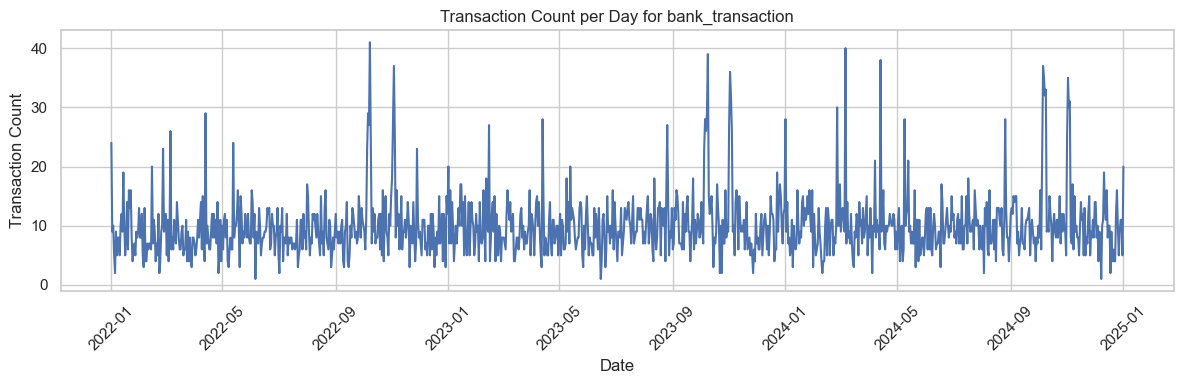

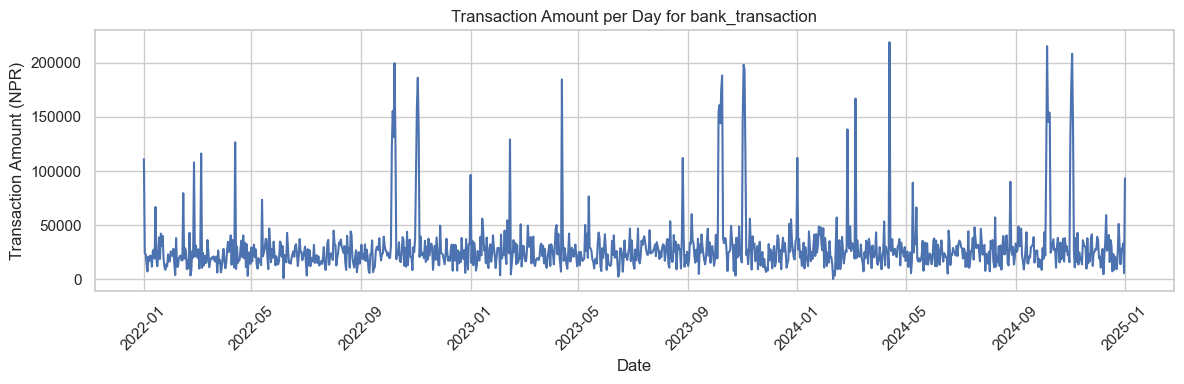

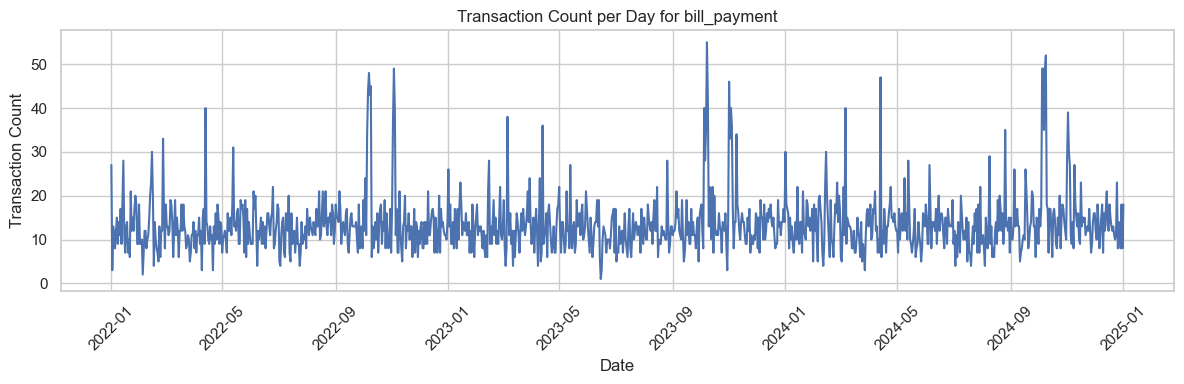

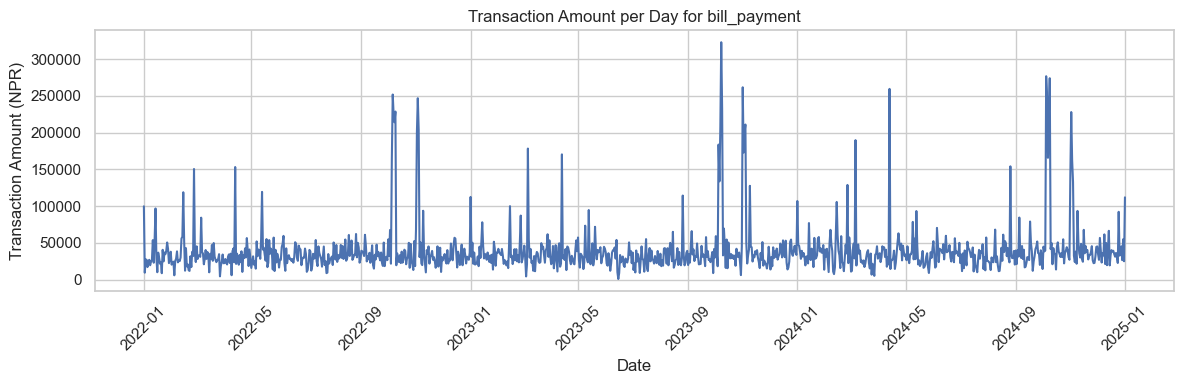

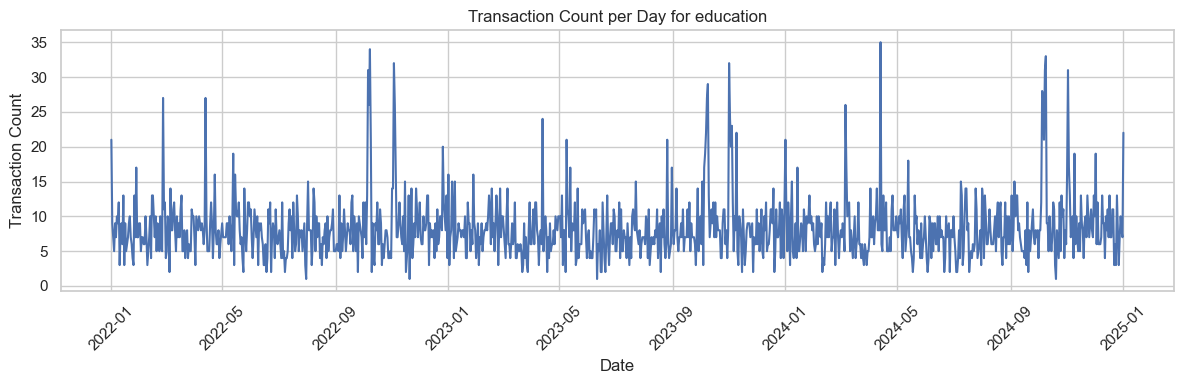

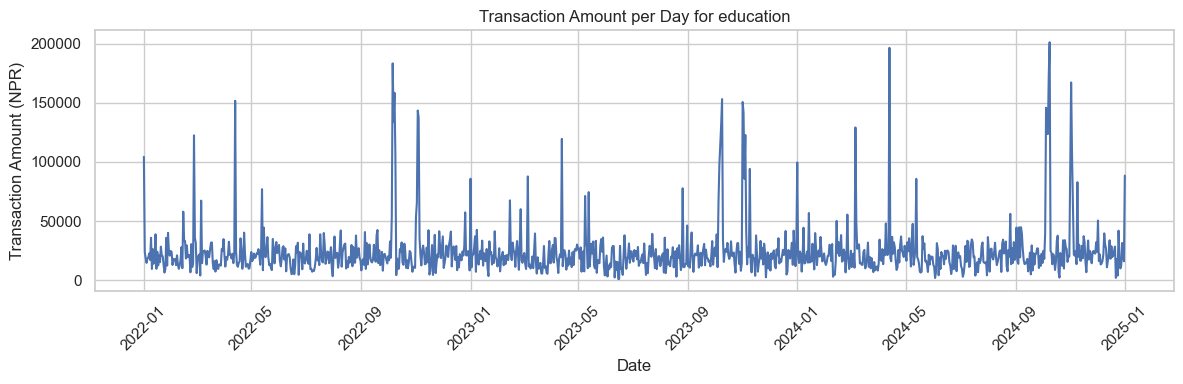

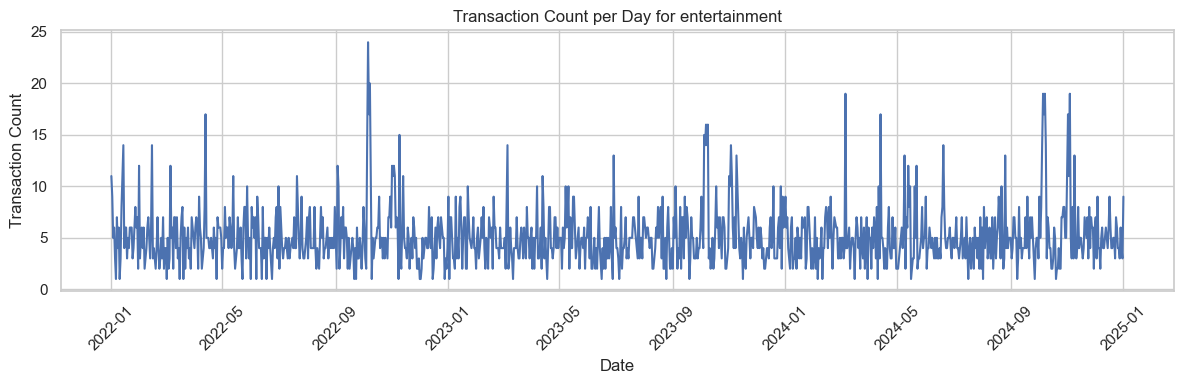

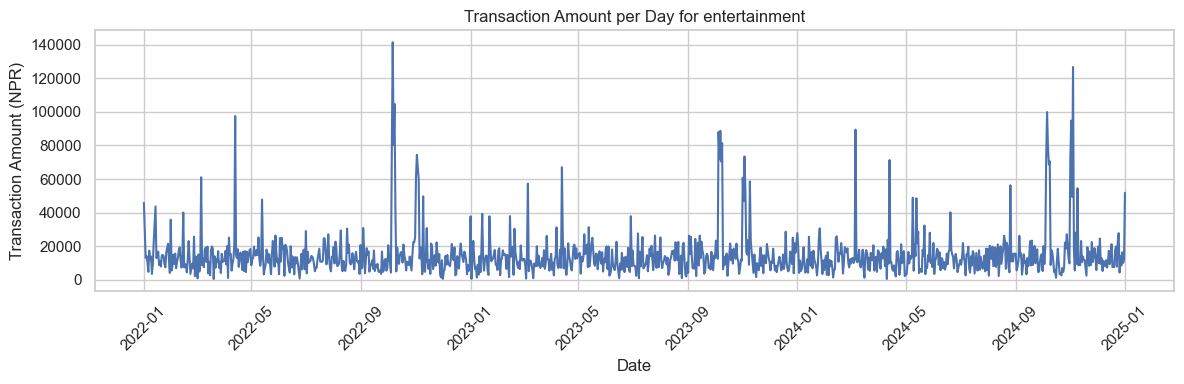

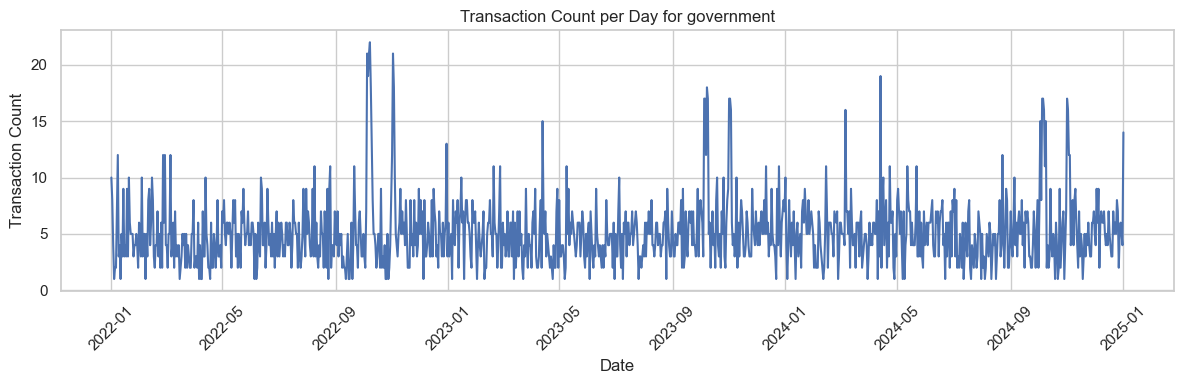

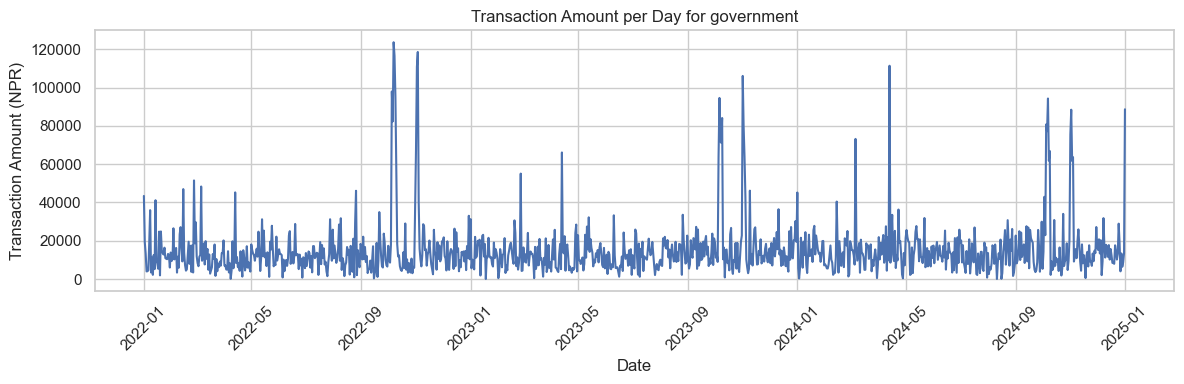

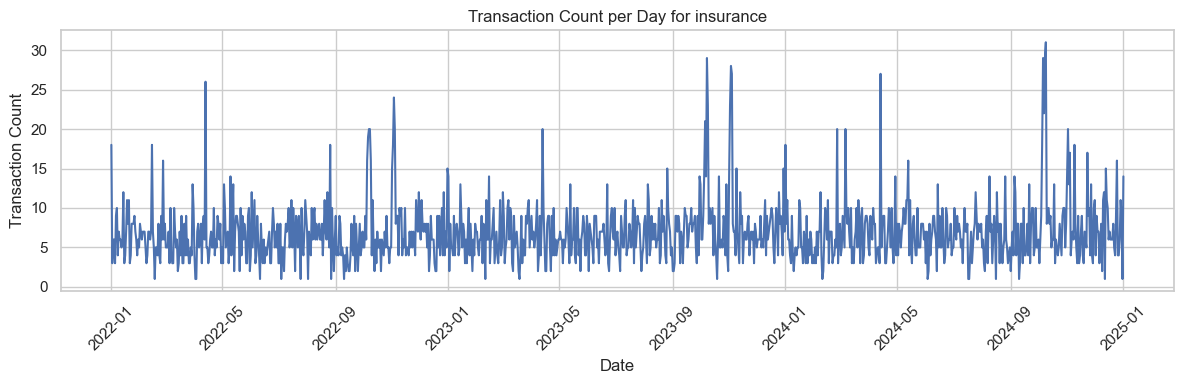

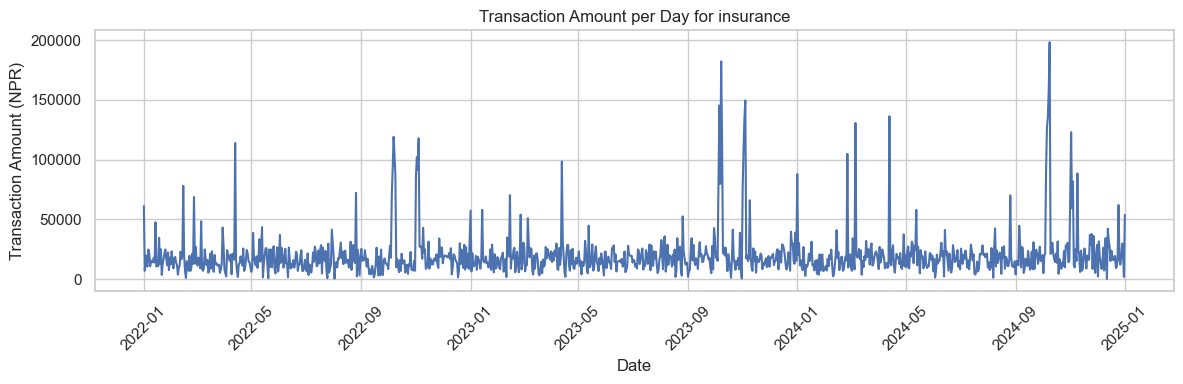

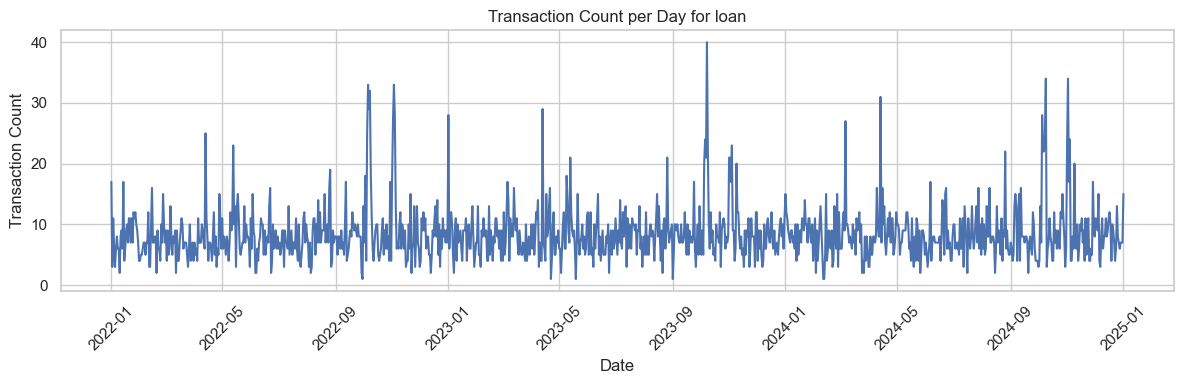

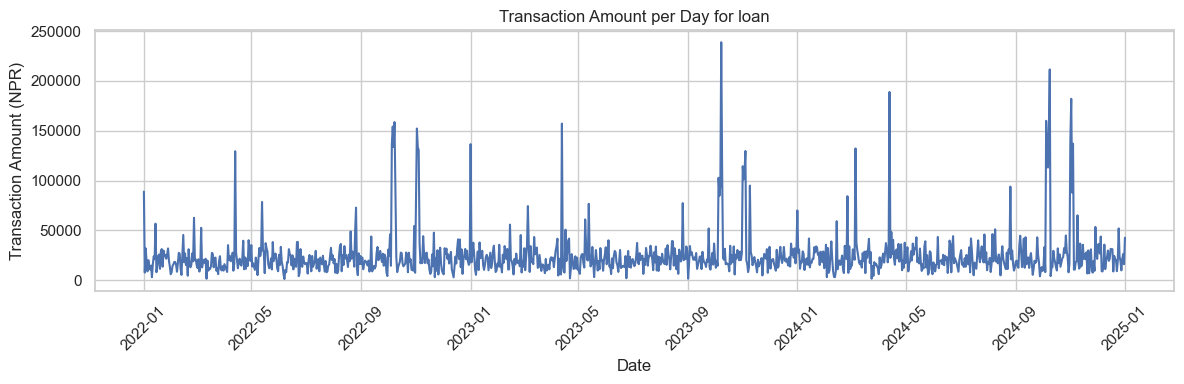

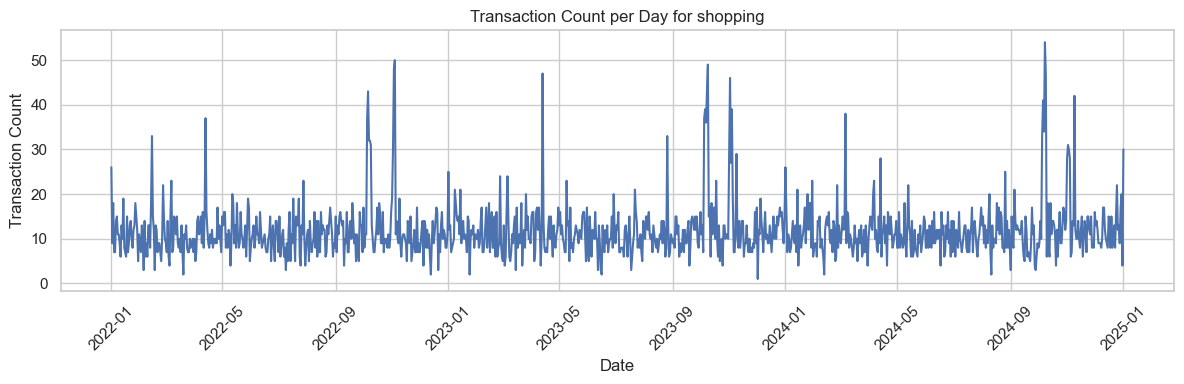

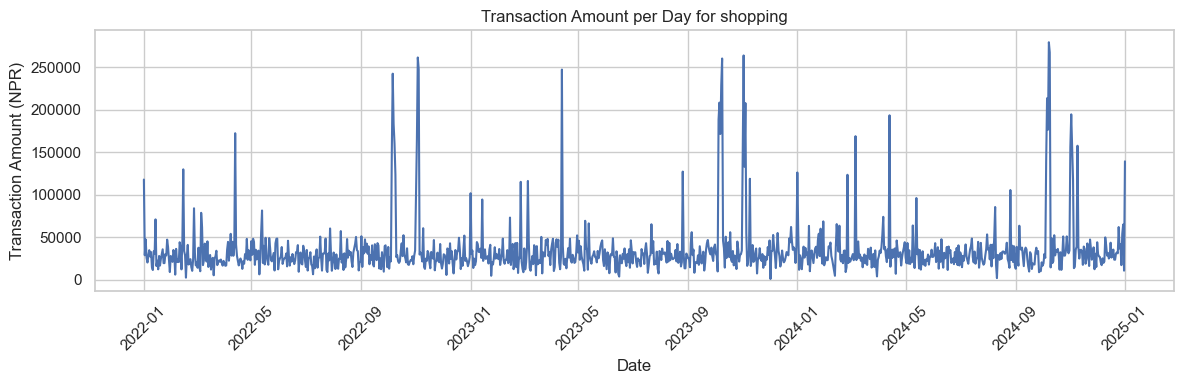

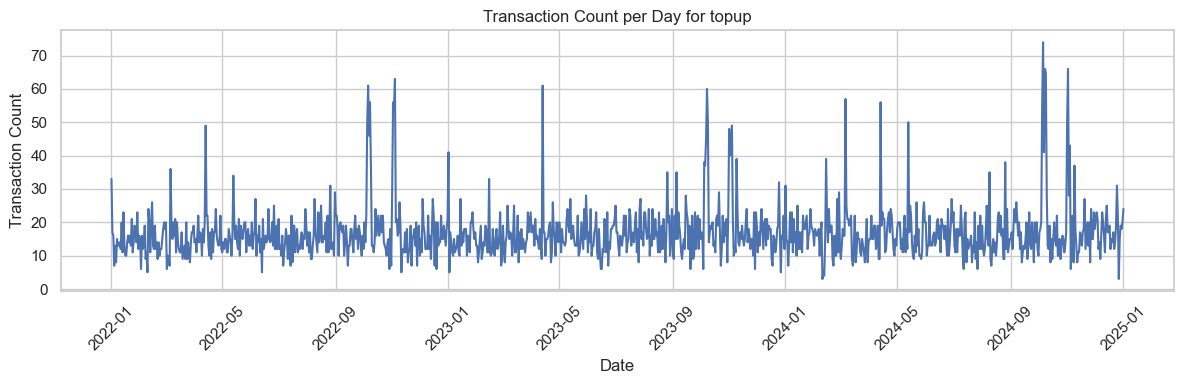

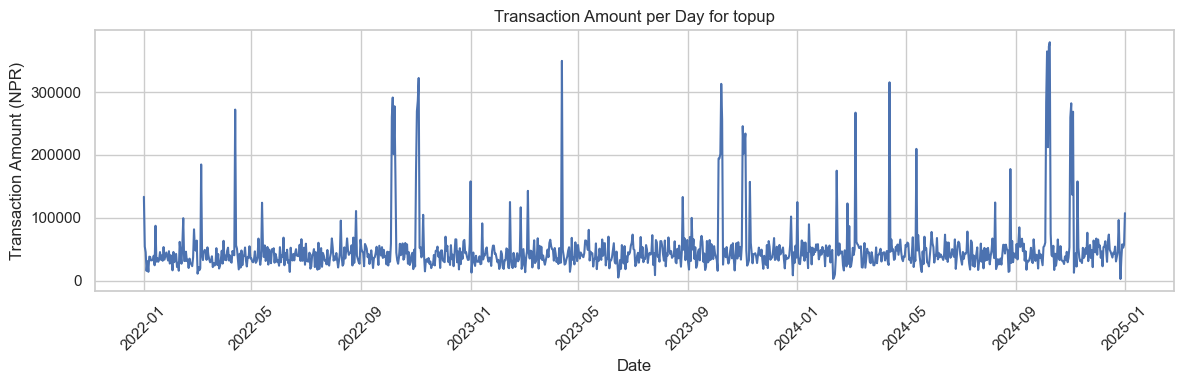

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Parse date and sort

df["category"] = df["category"].astype(str)

# Group by transaction_date and category
grouped = df.groupby(["transaction_date", "category"]).agg(
    transaction_count=("amount", "count"),
    transaction_amount=("amount", "sum")
).reset_index()

# Unique categories
categories = grouped["category"].unique()

# Set style
sns.set(style="whitegrid")

# Plot for each category
for cat in categories:
    cat_data = grouped[grouped["category"] == cat]

    # Count Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cat_data, x="transaction_date", y="transaction_count")
    plt.title(f"Transaction Count per Day for {cat}")
    plt.xlabel("Date")
    plt.ylabel("Transaction Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Amount Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cat_data, x="transaction_date", y="transaction_amount")
    plt.title(f"Transaction Amount per Day for {cat}")
    plt.xlabel("Date")
    plt.ylabel("Transaction Amount (NPR)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
